In [8]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("Movie-Capstone").getOrCreate()
sc = spark.sparkContext

users_data = [
    (1, "Rahul", 25, "Bangalore"),
    (2, "Priya", 30, "Delhi"),
    (3, "Aman", 22, "Hyderabad"),
    (4, "Sneha", 28, "Chennai"),
    (5, "Arjun", 35, "Mumbai")
]
users_cols = ["user_id", "name", "age", "city"]
users_df = spark.createDataFrame(users_data, users_cols)

movies_data = [
    (101, "Inception", "Sci-Fi", 2010),
    (102, "Avengers", "Action", 2012),
    (103, "3 Idiots", "Comedy", 2009),
    (104, "Dangal", "Drama", 2016),
    (105, "Interstellar", "Sci-Fi", 2014)
]
movies_cols = ["movie_id", "title", "genre", "year"]
movies_df = spark.createDataFrame(movies_data, movies_cols)

ratings_data = [
    (1, 101, 5),
    (2, 101, 4),
    (1, 102, 3),
    (3, 103, 4),
    (4, 104, 5),
    (2, 103, 5),
    (5, 105, 4),
    (6, 101, 5)
]
ratings_cols = ["user_id", "movie_id", "rating"]
ratings_df = spark.createDataFrame(ratings_data, ratings_cols)

In [9]:
# 1
users_df.filter(users_df.age > 28).show()
# 2
movies_df.select("genre").distinct().show()
# 3
movies_df.filter(movies_df.year > 2010).show()

+-------+-----+---+------+
|user_id| name|age|  city|
+-------+-----+---+------+
|      2|Priya| 30| Delhi|
|      5|Arjun| 35|Mumbai|
+-------+-----+---+------+

+------+
| genre|
+------+
|Action|
|Sci-Fi|
| Drama|
|Comedy|
+------+

+--------+------------+------+----+
|movie_id|       title| genre|year|
+--------+------------+------+----+
|     102|    Avengers|Action|2012|
|     104|      Dangal| Drama|2016|
|     105|Interstellar|Sci-Fi|2014|
+--------+------------+------+----+



In [10]:
# 4
users_df.groupBy("city").agg(F.avg("age").alias("avg_age")).show()
# 5
ratings_df.groupBy("movie_id").agg(F.avg("rating").alias("avg_rating")).show()
# 6
ratings_with_movies = ratings_df.join(movies_df, "movie_id")
ratings_with_movies.groupBy("genre","movie_id","title").agg(F.avg("rating").alias("avg_rating")) \
    .withColumn("rank", F.rank().over(Window.partitionBy("genre").orderBy(F.desc("avg_rating")))) \
    .filter("rank=1").show()

+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   25.0|
|    Delhi|   30.0|
|  Chennai|   28.0|
|   Mumbai|   35.0|
|Hyderabad|   22.0|
+---------+-------+

+--------+-----------------+
|movie_id|       avg_rating|
+--------+-----------------+
|     103|              4.5|
|     101|4.666666666666667|
|     102|              3.0|
|     104|              5.0|
|     105|              4.0|
+--------+-----------------+

+------+--------+---------+-----------------+----+
| genre|movie_id|    title|       avg_rating|rank|
+------+--------+---------+-----------------+----+
|Action|     102| Avengers|              3.0|   1|
|Comedy|     103| 3 Idiots|              4.5|   1|
| Drama|     104|   Dangal|              5.0|   1|
|Sci-Fi|     101|Inception|4.666666666666667|   1|
+------+--------+---------+-----------------+----+



In [11]:
# 7
ratings_df.join(users_df, "user_id", "inner").show()
# 8
ratings_df.join(movies_df, "movie_id", "inner").show()
# 9
users_df.join(ratings_df, "user_id", "left_anti").show()
# 10
movies_df.join(ratings_df, "movie_id", "left_anti").show()

+-------+--------+------+-----+---+---------+
|user_id|movie_id|rating| name|age|     city|
+-------+--------+------+-----+---+---------+
|      1|     101|     5|Rahul| 25|Bangalore|
|      1|     102|     3|Rahul| 25|Bangalore|
|      2|     101|     4|Priya| 30|    Delhi|
|      2|     103|     5|Priya| 30|    Delhi|
|      3|     103|     4| Aman| 22|Hyderabad|
|      4|     104|     5|Sneha| 28|  Chennai|
|      5|     105|     4|Arjun| 35|   Mumbai|
+-------+--------+------+-----+---+---------+

+--------+-------+------+------------+------+----+
|movie_id|user_id|rating|       title| genre|year|
+--------+-------+------+------------+------+----+
|     101|      1|     5|   Inception|Sci-Fi|2010|
|     101|      2|     4|   Inception|Sci-Fi|2010|
|     101|      6|     5|   Inception|Sci-Fi|2010|
|     102|      1|     3|    Avengers|Action|2012|
|     103|      3|     4|    3 Idiots|Comedy|2009|
|     103|      2|     5|    3 Idiots|Comedy|2009|
|     104|      4|     5|      Dan

In [12]:
# 11
users_df.createOrReplaceTempView("users")
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")
# 12
spark.sql("""
    SELECT u.city, COUNT(r.rating) AS total_ratings
    FROM ratings r
    JOIN users u ON r.user_id=u.user_id
    GROUP BY u.city
    ORDER BY total_ratings DESC
    LIMIT 2
""").show()
# 13
spark.sql("""
    SELECT DISTINCT u.name
    FROM ratings r
    JOIN users u ON r.user_id=u.user_id
    WHERE r.rating=5
""").show()
# 14
spark.sql("""
    SELECT m.genre, COUNT(r.rating) AS rating_count
    FROM ratings r
    JOIN movies m ON r.movie_id=m.movie_id
    GROUP BY m.genre
    ORDER BY rating_count DESC
    LIMIT 1
""").show()

+---------+-------------+
|     city|total_ratings|
+---------+-------------+
|Bangalore|            2|
|    Delhi|            2|
+---------+-------------+

+-----+
| name|
+-----+
|Sneha|
|Priya|
|Rahul|
+-----+

+------+------------+
| genre|rating_count|
+------+------------+
|Sci-Fi|           4|
+------+------------+



In [13]:
# 15
ratings_df.write.mode("overwrite").csv("/content/ratings_csv", header=True)
# 16
ratings_loaded = spark.read.csv("/content/ratings_csv", header=True, inferSchema=True)
movies_df.write.mode("overwrite").json("/content/movies_json")
movies_loaded = spark.read.json("/content/movies_json")

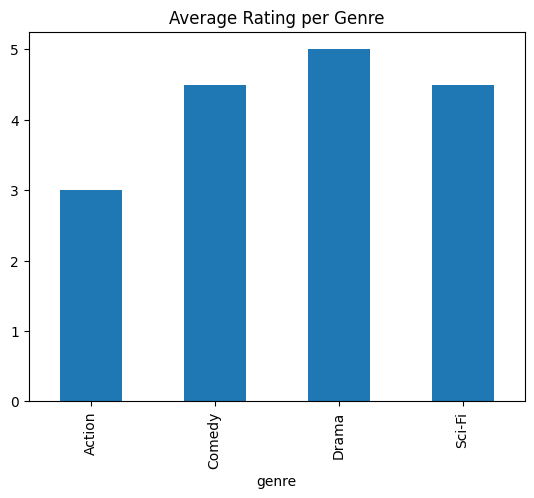

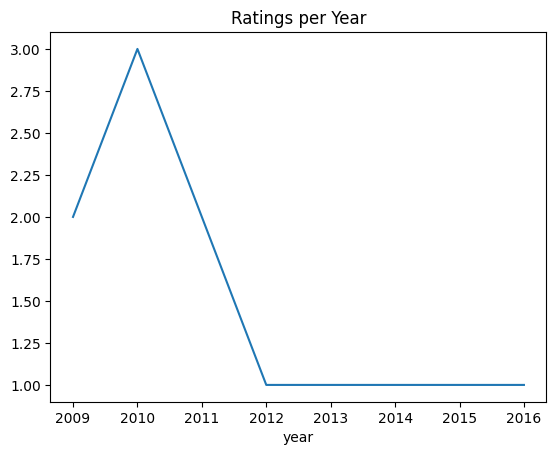

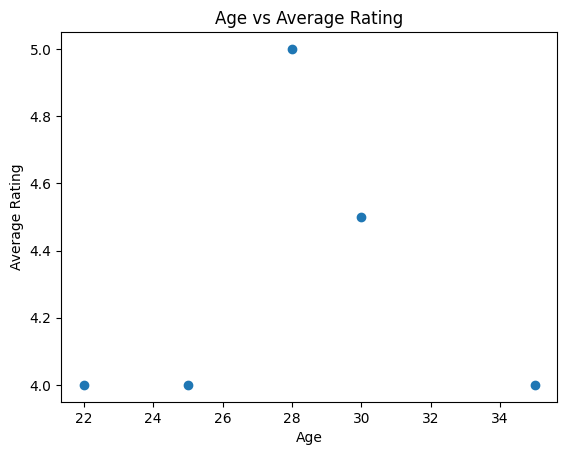

In [15]:
# 18
ratings_with_movies_pd = ratings_with_movies.toPandas()
avg_rating_genre = ratings_with_movies_pd.groupby("genre")["rating"].mean()
avg_rating_genre.plot(kind="bar", title="Average Rating per Genre")
plt.show()
# 19
ratings_with_movies_pd.groupby("year")["rating"].count().plot(kind="line", title="Ratings per Year")
plt.show()
# 20
user_ratings = ratings_df.join(users_df, "user_id").groupBy("age").agg(F.avg("rating").alias("avg_rating"))
user_ratings_pd = user_ratings.toPandas()
plt.scatter(user_ratings_pd["age"], user_ratings_pd["avg_rating"])
plt.xlabel("Age")
plt.ylabel("Average Rating")
plt.title("Age vs Average Rating")
plt.show()